### 用pymc实施MCMC

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
from pymc import *
from numpy import array, empty
from numpy.random import randint

# 矿难的发生数
disasters_array = array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

(1851, 1962)

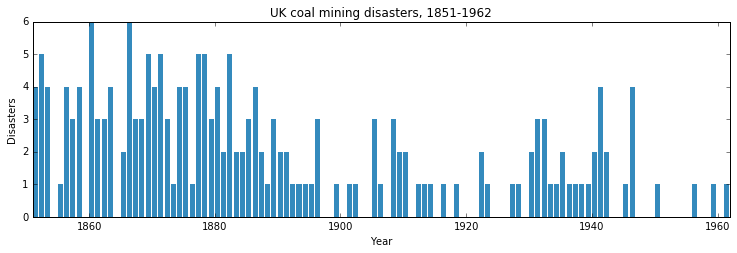

In [5]:
# 1851年到1962年间英国煤矿矿难发生数字
plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_array, color="#348ABD",linewidth=0)
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962)
# plt.plot(np.arange(1851, 1962), expected, lw=4, color="#E24A33",
#          label="expected number of text-messages received")

- 从图上看矿难发生数字有一个转折点，之前的数字比较高，之后的数字比较低。
- 我们需要利用贝叶斯方法对此建模，并找到三个相关参数的分布，即转折点的时间，前期的发生均值，后期的发生均值。
- 假设转折点$\tau$为均匀分布
- 假设前期发生数服从possion分布，参数为$\lambda_1$
- 假设后期发生数服从possion分布，参数为$\lambda_2$

$$\begin{array}{ccc}  
(y_t | \tau, \lambda_1, \lambda_2) \sim\text{Poisson}\left(r_t\right), & r_t=\left\{
\begin{array}{lll}             
\lambda_1 &\text{if}& t< \tau\\ 
\lambda_2 &\text{if}& t\ge \tau             
\end{array}\right.,&t\in[t_l,t_h]\\         
\tau \sim \text{DiscreteUniform}(t_l, t_h)\\         
\lambda_1\sim \text{Exponential}(a)\\         
\lambda_2\sim \text{Exponential}(b)     
\end{array}$$

- 先定义各随机变量和观测

In [6]:
# 定义先验概率分布
# 转折点服从一个离散均匀分布
switchpoint = DiscreteUniform(
    'switchpoint',
    lower=0,
    upper=110)

# 前期矿难的发生服从poisson分布，此分布的参数服从一个beta为1的指数分布。
early_mean = Exponential('early_mean', beta=1.)

# 后期矿难的发生服从poisson分布，此分布的参数服从一个beta为1的指数分布。
late_mean = Exponential('late_mean', beta=1.)

# 用装饰器定义rate和其它变量的确定性关系
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

# 定义观测数据的分布函数，ovserved为真表示此变量的数值不发生改变
disasters = Poisson('disasters', mu=rate, value=disasters_array, observed=True)

In [7]:
# 变量间存在依存关系，例如rate依赖于三个变量，而rate又是disasters的参数
rate.parents
rate.children

{<pymc.distributions.Poisson 'disasters' at 0x7ff7df506c50>}

In [11]:
# 变量内存放着数值，随机变量会给一个随机初值
switchpoint.value

array(86)

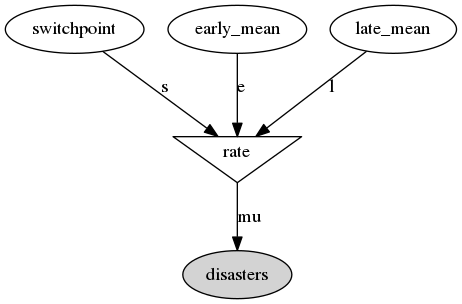

In [12]:
from pymc import graph, MCMC
graph.dag(MCMC([switchpoint, rate, early_mean, late_mean, disasters]))
!dot MCMC.dot -Tpng -o dag.png
from IPython.core.display import Image
Image('dag.png')

In [13]:
# 建立模型，将五个变量放进来
mymodel = pymc.Model([switchpoint,
                      early_mean,
                      late_mean,
                      rate,
                      disasters])
M = MCMC(mymodel)

In [14]:
# sample方法来运行模拟过程， burn参数表示放弃最前面的1000个数值，thin参数表示抽10分之1的数值以避免自相关
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.5 sec

In [15]:
# 输出的是一个trace
M.trace('switchpoint')[100:110]

array([46, 46, 46, 36, 39, 39, 39, 42, 40, 36])

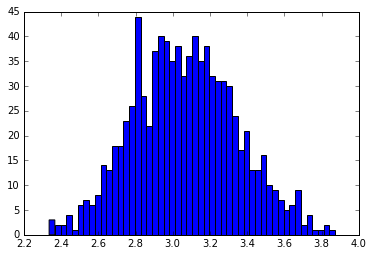

In [16]:
# 观察参数的后验分布
plt.hist(M.trace('early_mean')[:],bins=50);

Plotting late_mean
Plotting switchpoint
Plotting early_mean


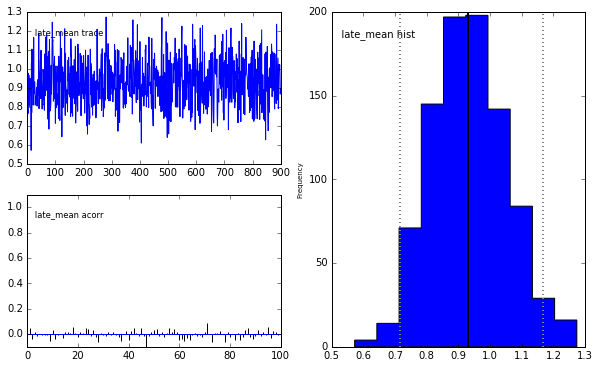

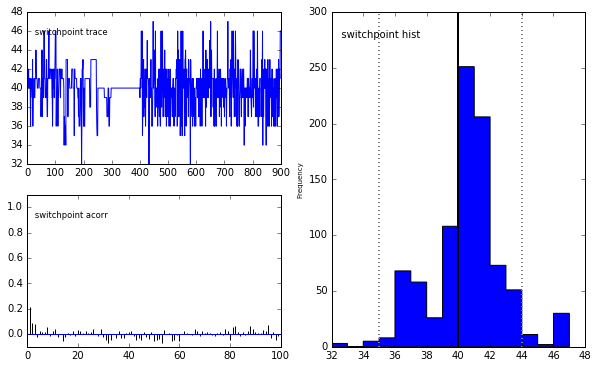

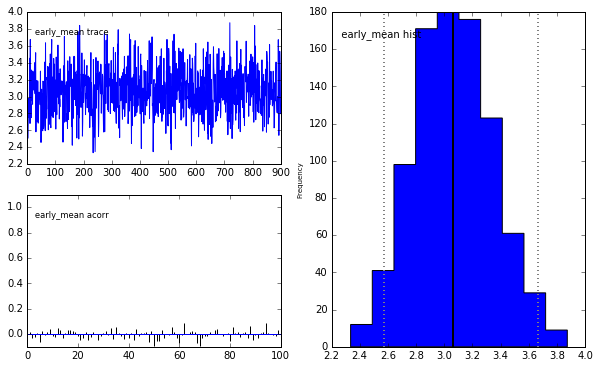

In [17]:
# 输出所有参数的分布图
pymc.Matplot.plot(M);

In [18]:
early = M.trace('early_mean')[:].mean()
late = M.trace('late_mean')[:].mean()
expected = [early]*40 + [late]*(1962-1851-40)

- 所结果可以看到，估计出的转折时间在1891年附件，之前的平均发生数是3次，之后的平均发生数是0.9次

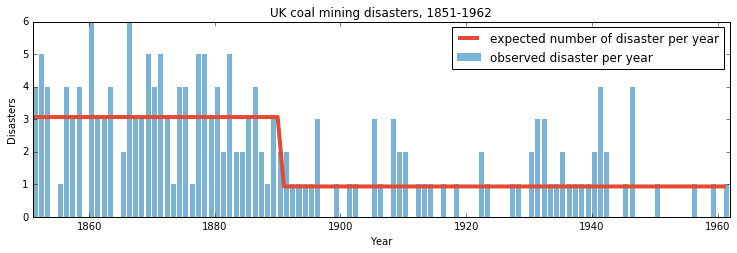

In [19]:
plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_array, color="#348ABD",linewidth=0,alpha=0.65,
        label="observed disaster per year")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962)
plt.plot(np.arange(1851, 1962), expected, lw=4, color="#E24A33",
         label="expected number of disaster per year")
plt.legend();